In [27]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [28]:
# Set plot style for visualizations
sns.set(style="whitegrid")

In [29]:
# 2. Load and Inspect the Dataset
# Load the dataset from the provided CSV file.
df = pd.read_csv('C:\\Users\Admin\Downloads\Dataset .csv')
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [30]:
# 3. Initial Data Cleaning and Preprocessing

df.drop(columns=['Restaurant Name', 'Restaurant ID', 'Address', 'Locality', 'Locality Verbose', 'Rating color', 'Rating text', 'Country Code', 'Currency'], axis=1, inplace=True)


In [31]:
# Remove rows where 'Aggregate rating' is 0, as these are "Not rated" restaurants.
df = df[df['Aggregate rating']!= 0].copy()

# Handle missing values in 'Cuisines' by imputing with the mode.
# This is a robust strategy for categorical features with few missing values.
df['Cuisines'].fillna(df['Cuisines'].mode(), inplace=True)

In [32]:
df.head()

,City,Longitude,Latitude,Cuisines,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Votes
0,Makati City,121.027535,14.565443,"French, Japanese, Desserts",1100,Yes,No,No,No,3,4.8,314
1,Makati City,121.014101,14.553708,Japanese,1200,Yes,No,No,No,3,4.5,591
2,Mandaluyong City,121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4000,Yes,No,No,No,4,4.4,270
3,Mandaluyong City,121.056475,14.585318,"Japanese, Sushi",1500,No,No,No,No,4,4.9,365
4,Mandaluyong City,121.057508,14.584450,"Japanese, Korean",1500,Yes,No,No,No,4,4.8,229


In [33]:
## 4. Feature Engineering
df['Cuisines'] = df['Cuisines'].astype(str)
# Create 'num_cuisines' by counting the number of cuisines offered.
df['num_cuisines'] = df['Cuisines'].apply(lambda x: len(x.split(',')))

# Identify the top 10 most frequent cuisines for one-hot encoding
top_cuisines = df['Cuisines'].str.split(', ').explode().value_counts().nlargest(10).index

# Create binary features for each of the top 10 cuisines (Bag-of-Words approach)
for cuisine in top_cuisines:
    df[f'Cuisine_{cuisine.replace(" ", "_")}'] = df['Cuisines'].apply(lambda x: 1 if cuisine in x else 0)

# Drop the original 'Cuisines' column as it has been replaced by engineered features
df.drop('Cuisines', axis=1, inplace=True)

# Convert binary categorical features ('Yes'/'No') to numerical (1/0)
binary_cols = ['Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu' ]
for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)

# One-Hot Encode the 'City' column. This avoids imposing an artificial order.
# We will keep only the top 30 cities to avoid creating too many features (curse of dimensionality).
top_cities = df['City'].value_counts().nlargest(30).index
df['City'] = df['City'].where(df['City'].isin(top_cities), 'Other')
city_dummies = pd.get_dummies(df['City'], prefix='City', drop_first=True)
df = pd.concat([df, city_dummies], axis=1)
df.drop('City', axis=1, inplace=True)

# Apply log transformation to skewed numerical features to normalize their distribution.
# Adding 1 to avoid log(0) which is undefined.
for col in ['Average Cost for two', 'Votes']:
    df[col] = np.log1p(df[col])

In [34]:
df.head()

,Longitude,Latitude,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Votes,...,City_New Delhi,City_Noida,City_Orlando,City_Other,City_Pensacola,City_Rest of Hawaii,City_Savannah,City_Singapore,City_Sioux City,City_Tampa Bay
0,121.027535,14.565443,7.003974,1,0,0,0,3,4.8,5.752573,...,False,False,False,True,False,False,False,False,False,False
1,121.014101,14.553708,7.090910,1,0,0,0,3,4.5,6.383507,...,False,False,False,True,False,False,False,False,False,False
2,121.056831,14.581404,8.294300,1,0,0,0,4,4.4,5.602119,...,False,False,False,True,False,False,False,False,False,False
3,121.056475,14.585318,7.313887,0,0,0,0,4,4.9,5.902633,...,False,False,False,True,False,False,False,False,False,False
4,121.057508,14.584450,7.313887,1,0,0,0,4,4.8,5.438079,...,False,False,False,True,False,False,False,False,False,False


In [35]:
# 5. Prepare Data for Modeling
# Separate features (X) and target variable (y)
X = df.drop('Aggregate rating', axis=1)
y = df['Aggregate rating']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# 6. Train and Evaluate Baseline Model: Linear Regression
# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on training and test sets
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate the model
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

In [37]:
# 7. Train and Evaluate Advanced Model: Random Forest Regressor
# Initialize and train the model with selected hyperparameters
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, min_samples_split=5, min_samples_leaf=2)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

# Print the performance comparison table
print("--- Model Performance Comparison ---")
print(f"{'Metric':<12} | {'Linear Regression':<20} | {'Random Forest':<20}")
print("-" * 60)
print(f"{'Train MAE':<12} | {lr_train_mae:<20.4f} | {rf_train_mae:<20.4f}")
print(f"{'Test MAE':<12} | {lr_test_mae:<20.4f} | {rf_test_mae:<20.4f}")
print(f"{'Train RMSE':<12} | {lr_train_rmse:<20.4f} | {rf_train_rmse:<20.4f}")
print(f"{'Test RMSE':<12} | {lr_test_rmse:<20.4f} | {rf_test_rmse:<20.4f}")
print(f"{'Train R²':<12} | {lr_train_r2:<20.4f} | {rf_train_r2:<20.4f}")
print(f"{'Test R²':<12} | {lr_test_r2:<20.4f} | {rf_test_r2:<20.4f}")
print("-" * 60)

--- Model Performance Comparison ---
Metric       | Linear Regression    | Random Forest       
------------------------------------------------------------
Train MAE    | 0.2675               | 0.1248              
Test MAE     | 0.2639               | 0.2431              
Train RMSE   | 0.3607               | 0.1776              
Test RMSE    | 0.3503               | 0.3286              
Train R²     | 0.5716               | 0.8962              
Test R²      | 0.6033               | 0.6509              
------------------------------------------------------------


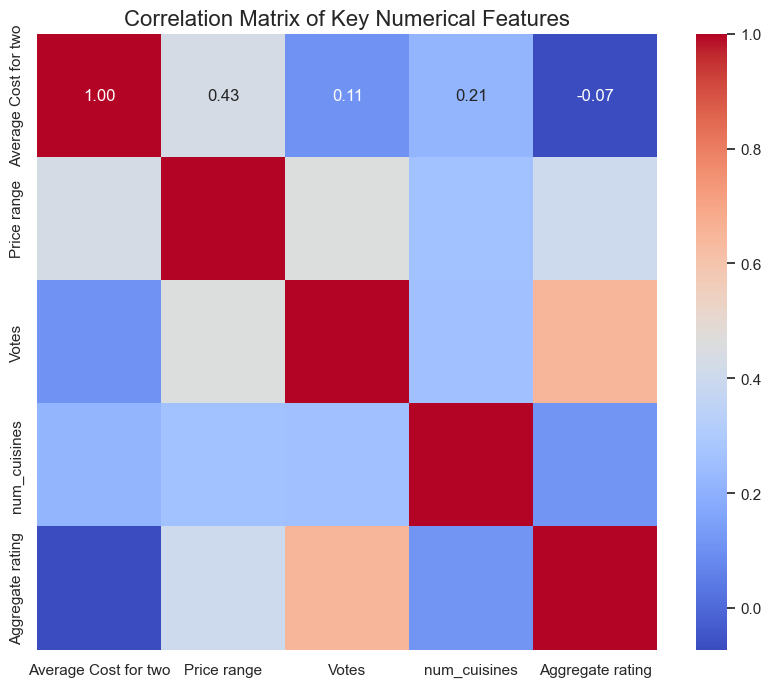

In [38]:
# 8. Correlation Analysis
# Select numerical features for correlation matrix
numerical_features = ['Average Cost for two', 'Price range', 'Votes', 'num_cuisines', 'Aggregate rating']
correlation_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Numerical Features', fontsize=16)
plt.show()


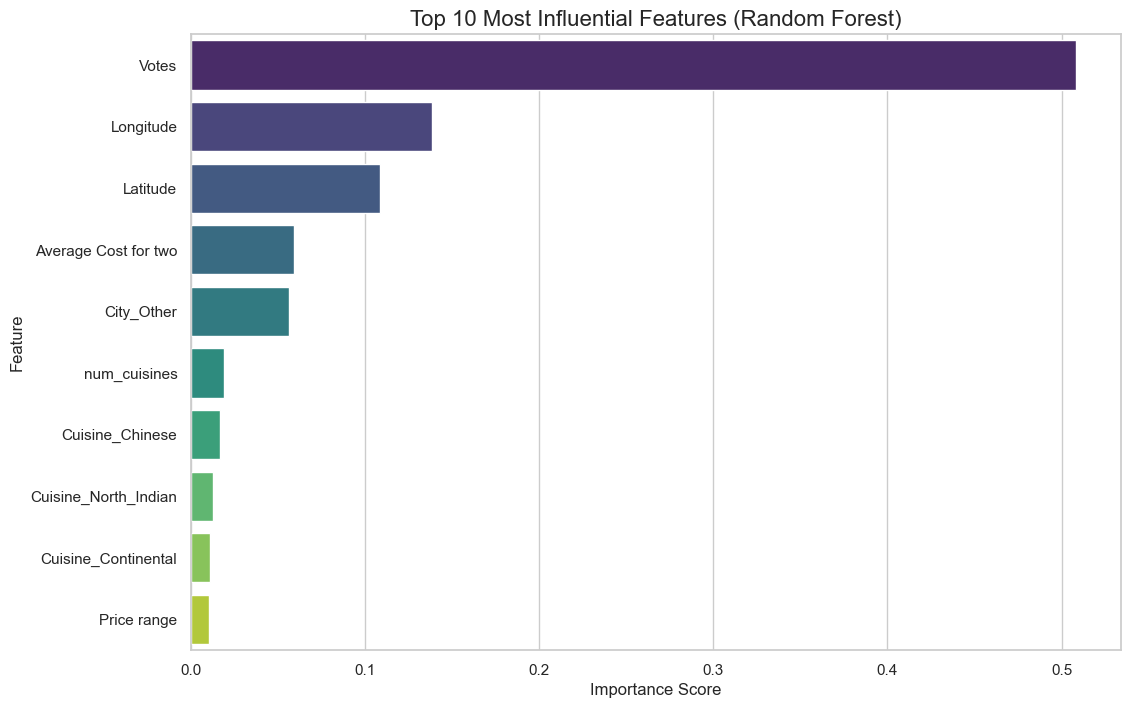


--- Top 10 Most Influential Features ---
             Feature  Importance
               Votes    0.508442
           Longitude    0.138472
            Latitude    0.108857
Average Cost for two    0.059080
          City_Other    0.056186
        num_cuisines    0.018975
     Cuisine_Chinese    0.016718
Cuisine_North_Indian    0.012851
 Cuisine_Continental    0.011310
         Price range    0.010588


In [39]:
# 9. Feature Importance from Random Forest
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Influential Features (Random Forest)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# Display the top 10 features in a table format
print("\n--- Top 10 Most Influential Features ---")
print(feature_importance_df.head(10).to_string(index=False))